In [1]:
#Control
import json
import os
import sys
import glob
import subprocess

#Ploting
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
import matplotlib.ticker as tick
rcParams['text.usetex'] = False
rcParams['lines.linewidth'] = 0.5
rcParams['font.size'] = 16

# Processing
import numpy as np
from statsmodels.tsa.stattools import adfuller

# For tabulating
import pandas as pd


# Import own modules
from time_series_data import time_series_data_c
from time_series_plotter import time_series_plotter_c

Using UQit in: /scratch/adperez/neko/examples/rbc_RA1e8/post_process/TimeSeries/../UQ/UQit_ts_module/UQit-ts/


# Read the data

In [2]:
files = sorted(glob.glob("*original.txt*"))
for i in range(0,len(files)):
    print("File "+repr(i) +" is: "+ files[i].strip())

data = []
for i in range(0,len(files)):
    dat = np.loadtxt(files[i].strip())
    data.append(dat)

File 0 is: 30001-rbc_RA1e8_nelv500k_original.txt
File 1 is: 30002-rbc_RA1e9_nelv500k_original.txt
File 2 is: 30003-rbc_RA1e10_nelv500k_original.txt
File 3 is: 30004-rbc_RA1e11_nelv500k_original.txt
File 4 is: 30005-rbc_RA1e12_nelv6m_original.txt
File 5 is: 30006-rbc_RA1e13_nelv6m_original.txt
File 6 is: 30007-rbc_RA1e14_nelv30m_original.txt
File 7 is: 30008-rbc_RA1e15_nelv30m_original.txt


# Initialize the relevant objects

In [3]:
i = 0
time_series =[]
ts_dict = {}


for dat in data:
    ts = time_series_data_c(dat)
    time_series.append(ts)

    # Check if this rayleigh number is already in the dictionary
    key = ts_dict.get(ts.Ra[0])
    if key is None: ts_dict[ts.Ra[0]] = [] 
    ts_dict[ts.Ra[0]].append(ts)
    

ts_plt = time_series_plotter_c()

# Plot all the time series independently

In [4]:
check_these_rayleigh = [1e10]

## Check the stationarity of the signals

In [5]:
how_many_intervals = 10 # To divide the series for the adf_test

#for which_ra in ts_dict.keys():
for which_ra in check_these_rayleigh:

    print("------ Now calculating for Ra = "+repr(which_ra)+ "---------------")

    for ts in ts_dict[which_ra]:
    
        # See where the transient is over
        ts.get_transients(int(len(ts.t)/how_many_intervals))

------ Now calculating for Ra = 10000000000.0---------------


 29%|████████████████████████████████████████████████▎                                                                                                                        | 2/7 [00:08<00:21,  4.26s/it]


## Plot the time series

True


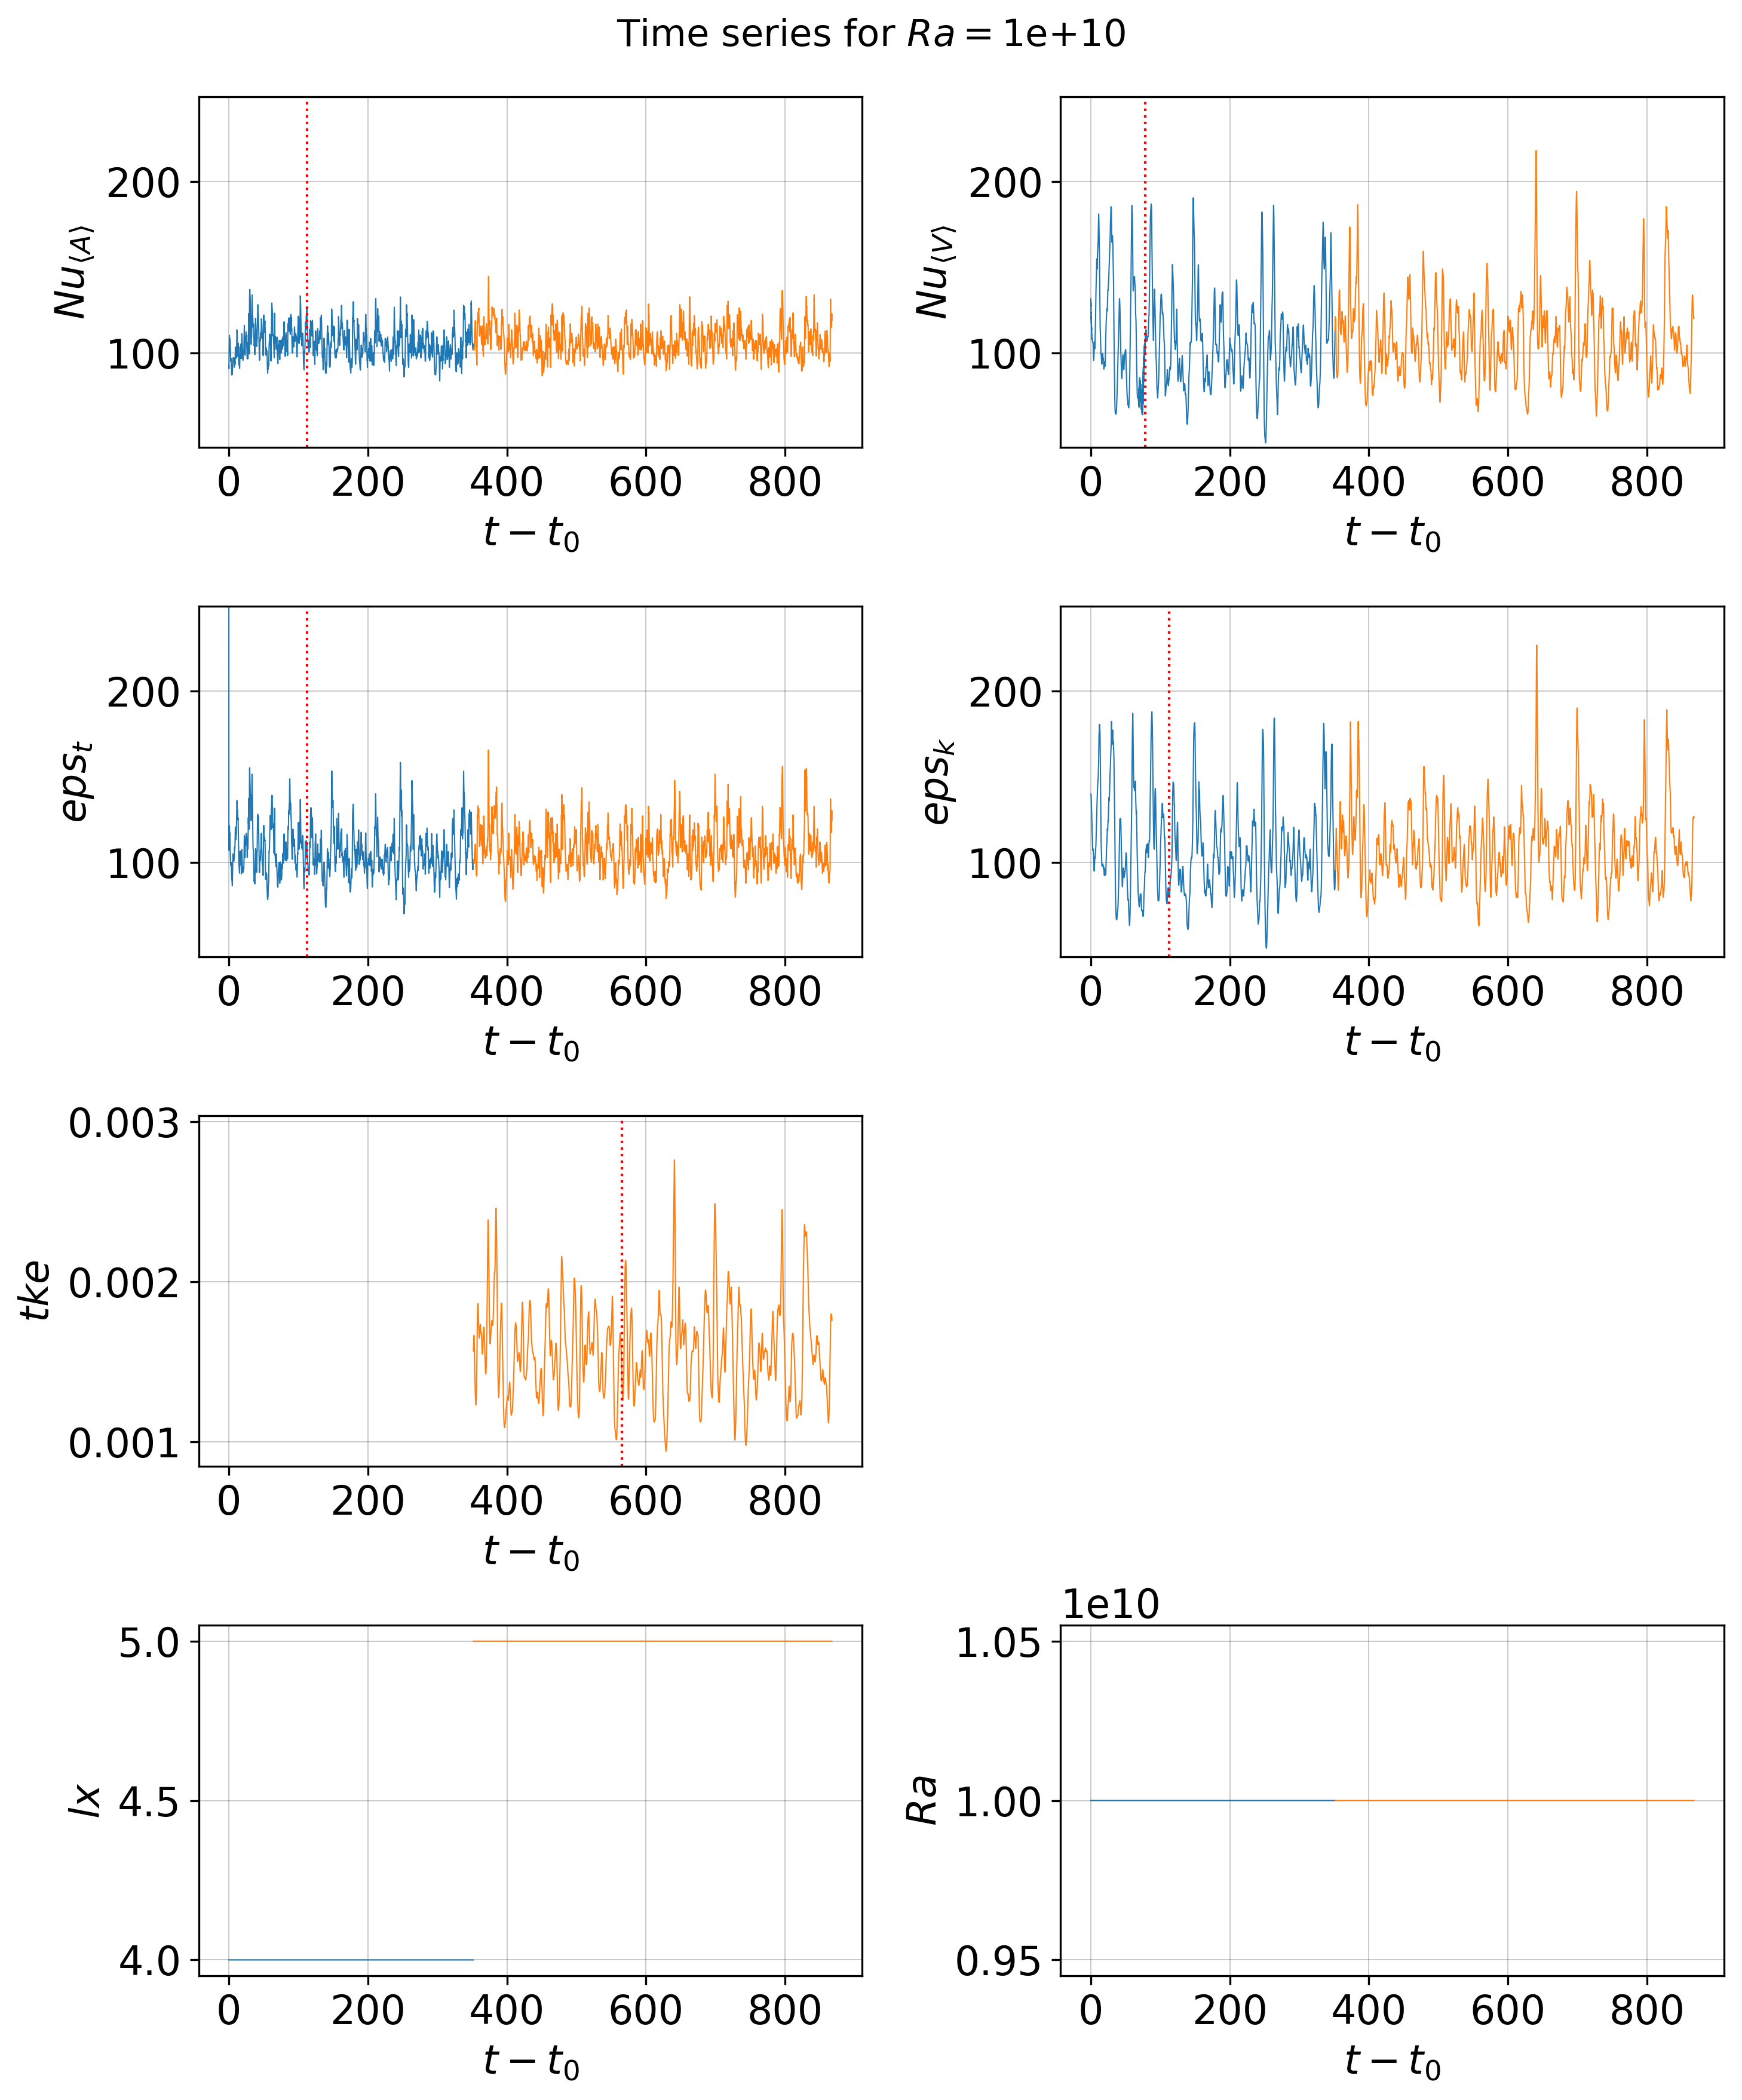

In [6]:
ts_plt.plot_ra_separate(ts_dict, check_these_rayleigh, plot_transient_end=1)

# Average the time series

## Find the optimal batch sizes

Ideally we want to have batches that are not autocorrelated among them. So we split our signal into "independent" batches.

In [7]:
for which_ra in check_these_rayleigh:
    
    print("------ Now calculating for Ra = "+repr(which_ra)+ "---------------")

    for ts in ts_dict[which_ra]:   
        # Get uncorrelated batch size
        ts.get_uncorrelated_batch(0)

------ Now calculating for Ra = 10000000000.0---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.36it/s]


[ 6  8 10 14 16 19 21 26 28]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:11<00:00,  4.90it/s]


[ 2  7  9 14 20 22 25]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:11<00:00,  4.84it/s]


[ 2  4  6 10 12 15 18 20 23 25]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:11<00:00,  4.87it/s]

[ 2  4 10 14 17 19 23]


## Apply the NOBM to calculate the averages

In [8]:
for which_ra in check_these_rayleigh:

    print("------ Now calculating for Ra = "+repr(which_ra)+ "---------------")

    for ts in ts_dict[which_ra]:   
        # Get uncorrelated batch size
        ts.get_stats()

------ Now calculating for Ra = 10000000000.0---------------


In [52]:
for which_ra in check_these_rayleigh:
    
    for ts in ts_dict[which_ra]:

        ra_string = '{:.0e}'.format(ts.Ra[-1])

        df = pd.DataFrame({
        "Ra="+ra_string : [""],
        "Nu": [""],
        "var": [""],
        "95% CI": [""]
        })

        new_row = {"Ra="+ra_string: "Nu_A", "Nu": ts.stats_nu_a[0], "var": ts.stats_nu_a[1], "95% CI": ts.stats_nu_a[2]}
        df.loc[0] = new_row

        new_row = {"Ra="+ra_string: "Nu_V", "Nu": ts.stats_nu_v[0], "var": ts.stats_nu_v[1], "95% CI": ts.stats_nu_v[2]}
        df.loc[1] = new_row

        new_row = {"Ra="+ra_string: "Nu_eps_t", "Nu": ts.stats_nu_eps_t[0], "var": ts.stats_nu_eps_t[1], "95% CI": ts.stats_nu_eps_t[2]}
        df.loc[2] = new_row

        new_row = {"Ra="+ra_string: "Nu_eps_k", "Nu": ts.stats_nu_eps_k[0], "var": ts.stats_nu_eps_k[1], "95% CI": ts.stats_nu_eps_k[2]}
        df.loc[3] = new_row
        
        display(df)

,Ra=1e+10,Nu,var,95% CI
0,Nu_A,106.667522,0.223958,0.927555
1,Nu_V,106.807719,0.813894,1.768235
2,Nu_eps_t,107.321977,0.423521,1.275539
3,Nu_eps_k,107.256203,1.232338,2.17581
